In [1]:
import importlib
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import re
from sklearn.model_selection import train_test_split

import load
import util

# 1. Pre-process training ECG data
- Convert raw ecg data to pickle files
- ecg, r_peaks, and atfs are reshaped into segments with 1-min long to pair with apn labels
- Removing first several minutes of problematic recording (usually when ecg is not recording or with abnormal signals)

In [2]:
train_full = [f'a{i:02d}' for i in range(
    1, 21)] + [f'b{i:02d}' for i in range(1, 6)] + [f'c{i:02d}' for i in range(1, 11)]
train_test = ['a01']
data_folder = '../data/training'
ratio_lb, ratio_ub = 0.6, 2

In [3]:
output_folder = '../data/processed'
diagPlot = False

for file in train_full:
    apn, t_apn = load.get_apn_train(f'{data_folder}/{file}')
    apn, ecg, r_peaks, atfs = load.single_file_res(data_folder, file, apn, t_apn[-1])
    
    # Delete segments with abnormal s.d.
    idx_valid = util.get_normal_segment_idx(
        ecg, ratio_lb, ratio_ub, diagPlot)
    if diagPlot:
        plt.title(file)
        plt.show()
    
    s_idx = np.where(idx_valid)[0][0]
    ecg = ecg[s_idx : , :]
    apn = apn[s_idx : ]
    r_peaks = r_peaks[s_idx : , :]
    atfs = atfs[s_idx : , :]
    
    # Save result
    res = {'ecg': ecg, 'apn': apn, 'r_peaks': r_peaks, 'atfs': atfs}
    with open(f'{output_folder}/{file}.pkl', 'wb') as f:
        pickle.dump(res, f)
        
    print(f'{file}: {s_idx} minutes discarded')


a01: 0 minutes discarded
a02: 0 minutes discarded
a03: 0 minutes discarded
a04: 0 minutes discarded
a05: 0 minutes discarded
a06: 0 minutes discarded
a07: 0 minutes discarded
a08: 0 minutes discarded
a09: 0 minutes discarded
a10: 0 minutes discarded
a11: 0 minutes discarded
a12: 0 minutes discarded
a13: 0 minutes discarded
a14: 0 minutes discarded
a15: 1 minutes discarded
a16: 0 minutes discarded
a17: 0 minutes discarded
a18: 0 minutes discarded
a19: 0 minutes discarded
a20: 0 minutes discarded
b01: 0 minutes discarded
b02: 0 minutes discarded
b03: 0 minutes discarded
b04: 9 minutes discarded
b05: 0 minutes discarded
c01: 10 minutes discarded
c02: 10 minutes discarded
c03: 0 minutes discarded
c04: 20 minutes discarded
c05: 0 minutes discarded
c06: 1 minutes discarded
c07: 0 minutes discarded
c08: 0 minutes discarded
c09: 13 minutes discarded
c10: 11 minutes discarded


# 2. Pre-process testing ECG data

In [4]:
test_full = [f'x{i:02d}' for i in range(1, 36)] 
data_folder = '../data/testing'
ratio_lb, ratio_ub = 0.6, 2

In [5]:
# Arrange labels for testing data
with open(f'{data_folder}/event-2-answers') as f:
    lines = f.read()

lines = lines.split(sep='\n\n')
lines = lines[:-1] # Delete the last empty item
lines = [line[3: ] for line in lines] # Delete leading filename
apns = [list(itertools.chain(*re.findall(r'[AN]+', line))) for line in lines]
d_apn = {'N': 0, 'A': 1}
apns = [np.array([d_apn[str] for str in apn]).astype(bool) for apn in apns]

with open(f'{data_folder}/event-2-answers.pkl', 'wb') as f:
    pickle.dump(apns, f)

In [6]:
output_folder = '../data/processed'
diagPlot = False
group_dict = {'A': 21, 'B': 6, 'C': 11}

with open(f'{data_folder}/event-2-answers.pkl', 'rb') as f:
    apns = pickle.load(f)
    
for file, apn in zip(test_full, apns):
    t_end = 60 * (len(apn) - 1)
    apn, ecg, r_peaks, atfs = load.single_file_res(data_folder, file, apn, t_end)
    
    # Delete segments with abnormal s.d.
    idx_valid = util.get_normal_segment_idx(ecg, ratio_lb, ratio_ub, diagPlot)
    s_idx = np.where(idx_valid)[0][0]
    ecg = ecg[s_idx : , :]
    apn = apn[s_idx : ]
    r_peaks = r_peaks[s_idx : , :]
    atfs = atfs[s_idx : , :]
    
    # Determine group
    group = util.ecg_diagnose(apn)
    file_name = f'{group.lower()}{group_dict[group]:02d}'
    group_dict[group] += 1
    
    if diagPlot:
        plt.title(f'{file} ({file_name})')
        plt.show()
                  
    # Save result
    res = {'ecg': ecg, 'apn': apn, 'r_peaks': r_peaks, 'atfs': atfs}
    with open(f'{output_folder}/{file_name}.pkl', 'wb') as f:
        pickle.dump(res, f)
        
    print(f'{file}: {s_idx} minutes discarded')

x01: 10 minutes discarded
x02: 0 minutes discarded
x03: 1 minutes discarded
x04: 9 minutes discarded
x05: 0 minutes discarded
x06: 5 minutes discarded
x07: 2 minutes discarded
x08: 0 minutes discarded
x09: 0 minutes discarded
x10: 0 minutes discarded
x11: 0 minutes discarded
x12: 0 minutes discarded
x13: 0 minutes discarded
x14: 0 minutes discarded
x15: 0 minutes discarded
x16: 0 minutes discarded
x17: 0 minutes discarded
x18: 15 minutes discarded
x19: 0 minutes discarded
x20: 1 minutes discarded
x21: 0 minutes discarded
x22: 11 minutes discarded
x23: 0 minutes discarded
x24: 14 minutes discarded
x25: 0 minutes discarded
x26: 1 minutes discarded
x27: 0 minutes discarded
x28: 10 minutes discarded
x29: 18 minutes discarded
x30: 0 minutes discarded
x31: 0 minutes discarded
x32: 0 minutes discarded
x33: 0 minutes discarded
x34: 0 minutes discarded
x35: 11 minutes discarded


# 3. Visualize all ECG data

In [ ]:
file_full = [f'a{i:02d}' for i in range(1, 41)] +\
    [f'b{i:02d}' for i in range(1, 11)] +\
    [f'c{i:02d}' for i in range(1, 21)]
data_folder = '../data/processed'
for file in file_full:
    with open(f'{data_folder}/{file}.pkl', 'rb') as f:
        res = pickle.load(f)
    
    plt.figure()
    plt.plot(res['ecg'].flatten())
    plt.title(file)
    plt.show()

# 4. Generate heart rate data
- Extract R-R interval from processed ECG data and calculate heart rate

In [ ]:
# Heart rate data for each patient
file_full = [f'a{i:02d}' for i in range(1, 41)] + \
    [f'b{i:02d}' for i in range(1, 11)] + \
    [f'c{i:02d}' for i in range(1, 21)]

for file in file_full:
    print(file)
    with open(f'../data/processed/{file}.pkl', 'rb') as f:
        data = pickle.load(f)
    
    t_hr, hr = [], []
    for minute in range(len(data['apn'])):
        t_hr_, hr_ = util.get_heart_rate(data['ecg'][minute])
        t_hr_ = t_hr_ / 60 + minute # Unit in minutes
        t_hr += list(t_hr_)
        hr += list(hr_)
        
    res = {'hr': np.array(hr), 't': np.array(t_hr), 'apn': data['apn']}
    with open(f'../HR_data/{file}.pkl', 'wb') as f:
        pickle.dump(res, f)

# 5. Visualize all heart rate data

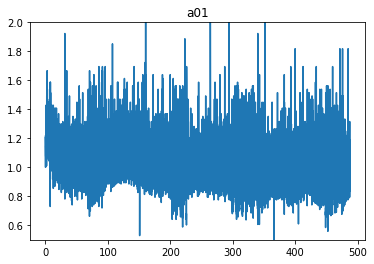

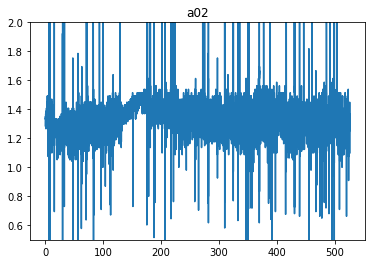

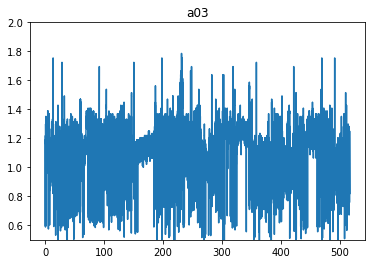

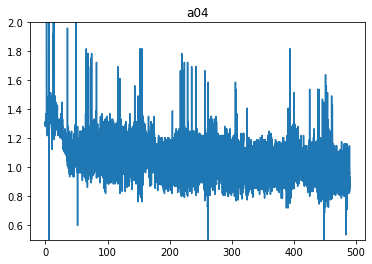

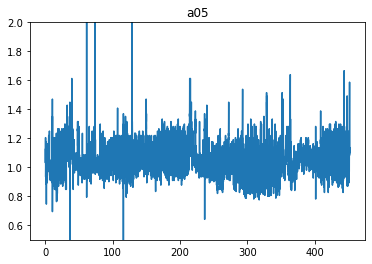

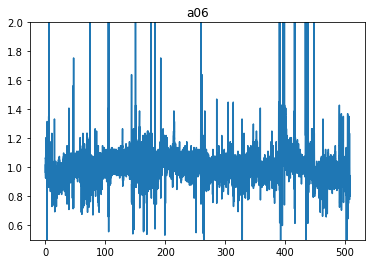

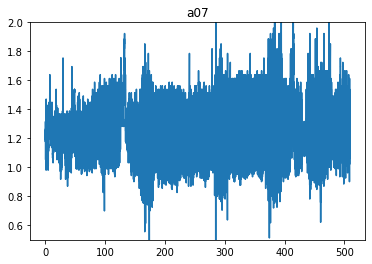

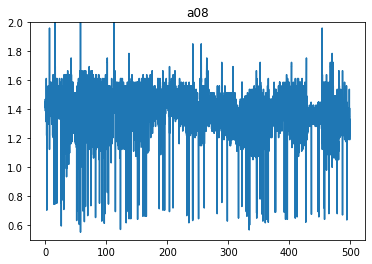

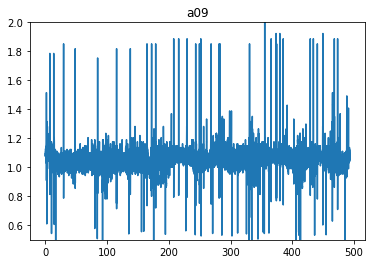

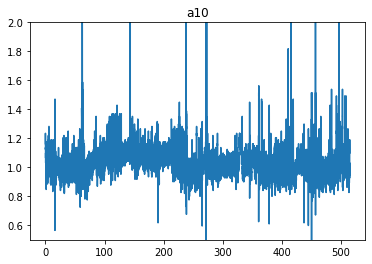

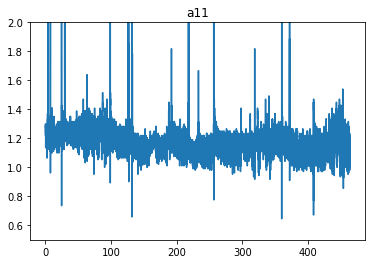

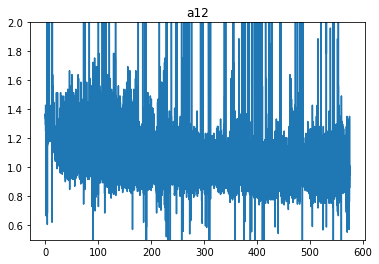

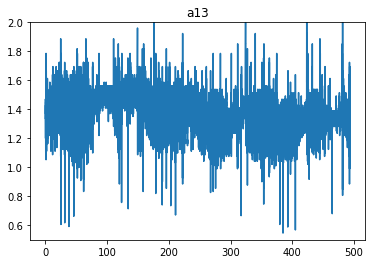

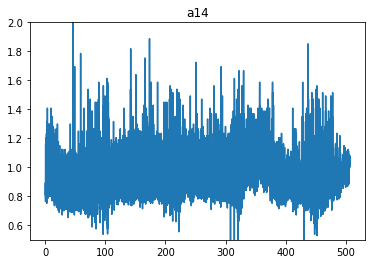

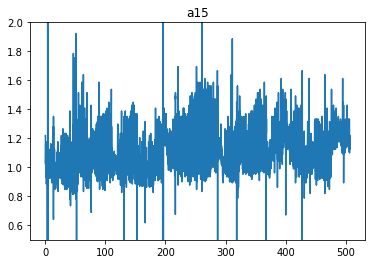

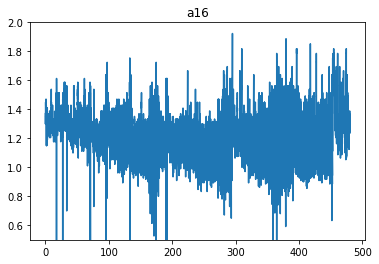

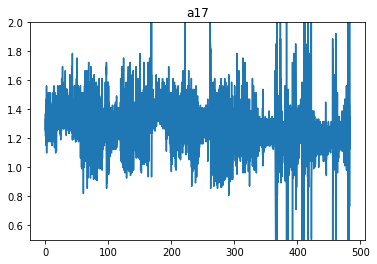

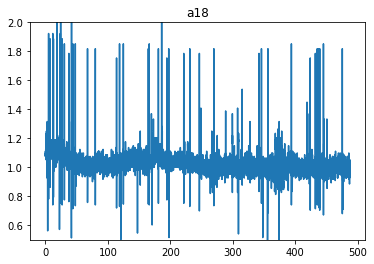

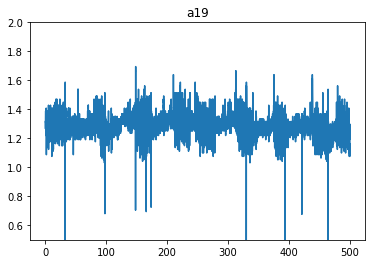

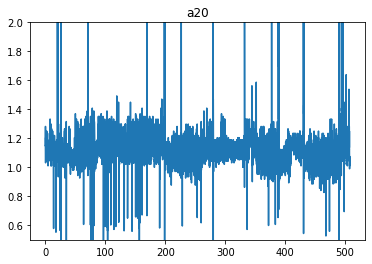

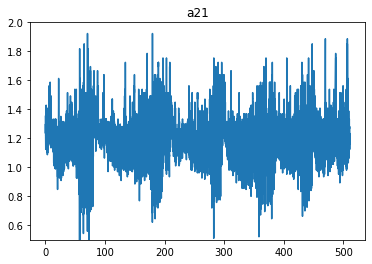

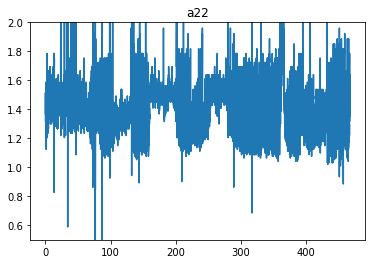

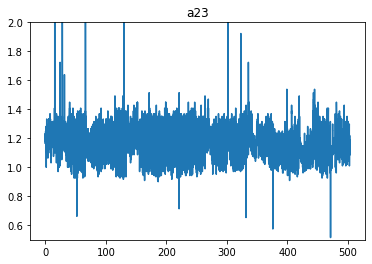

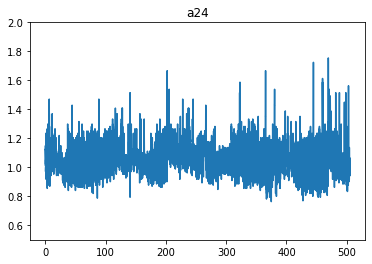

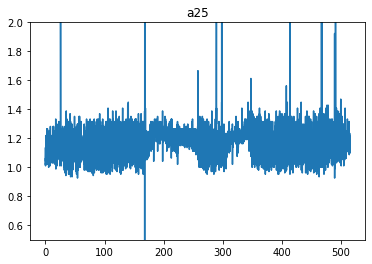

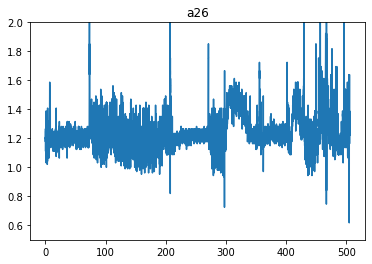

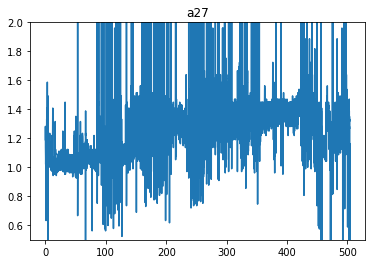

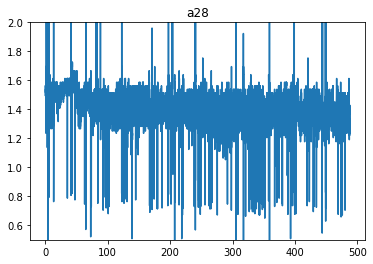

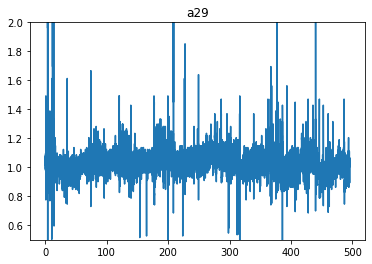

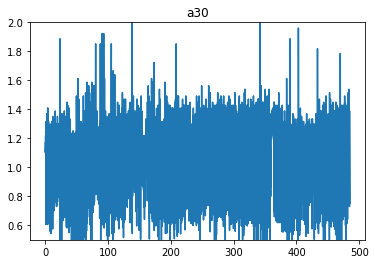

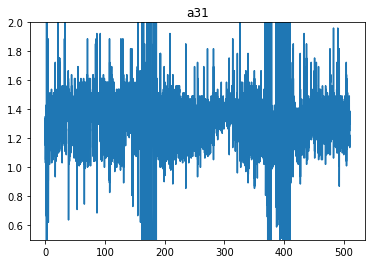

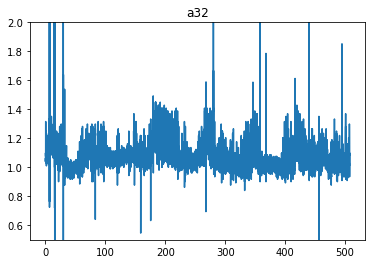

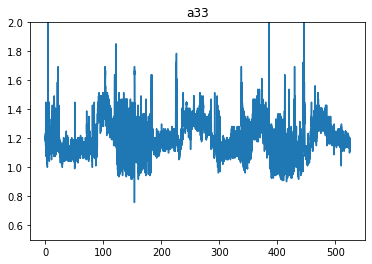

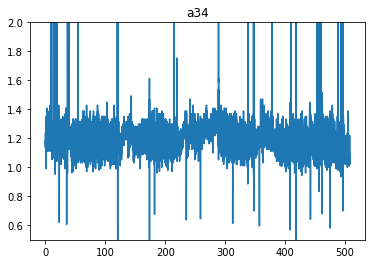

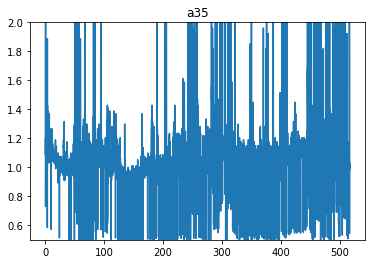

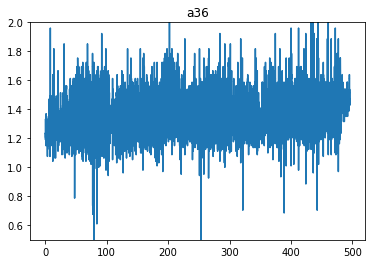

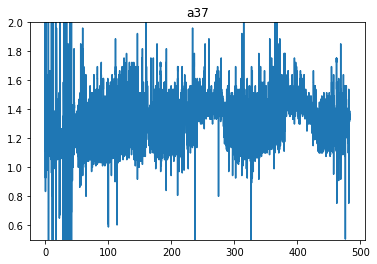

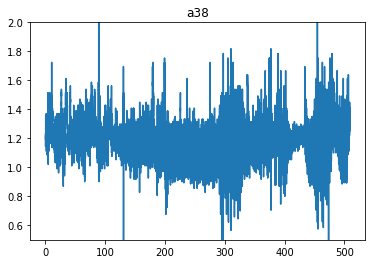

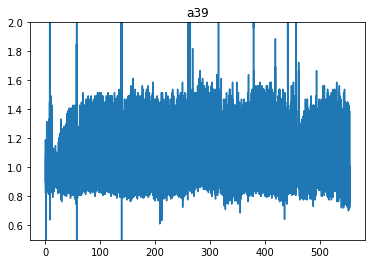

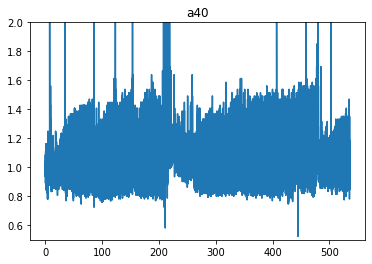

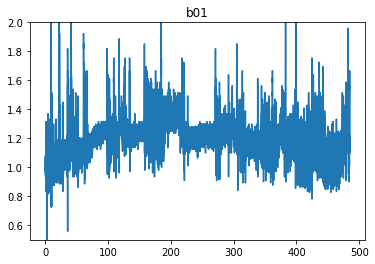

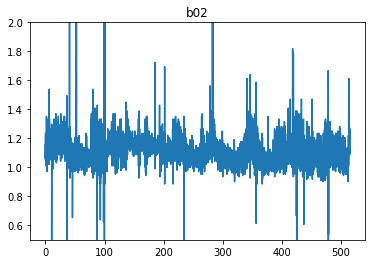

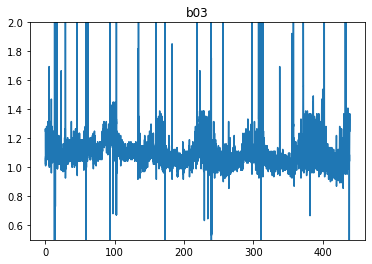

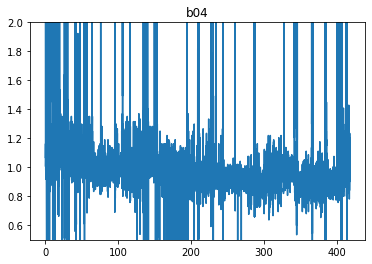

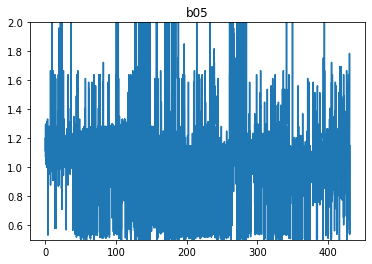

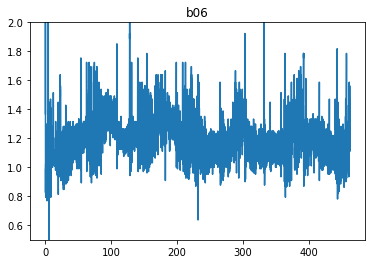

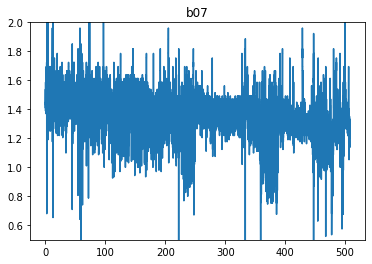

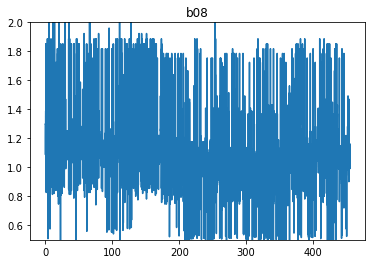

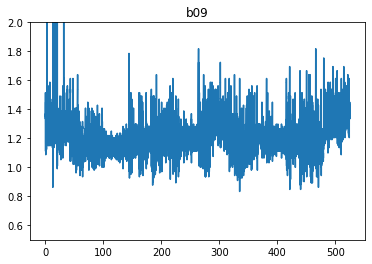

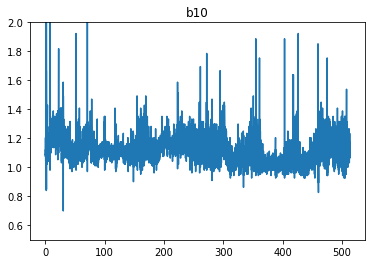

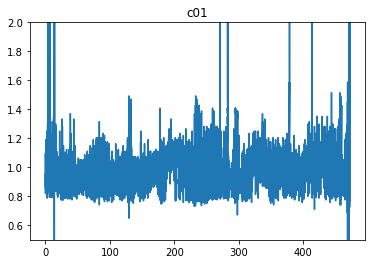

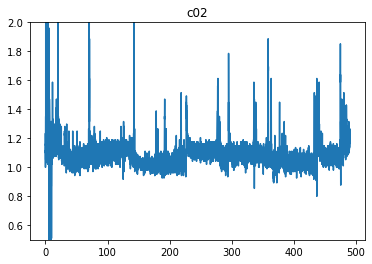

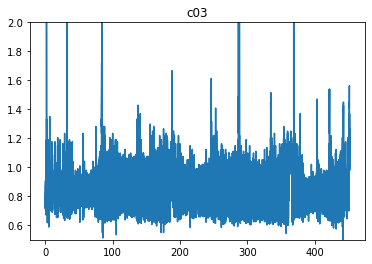

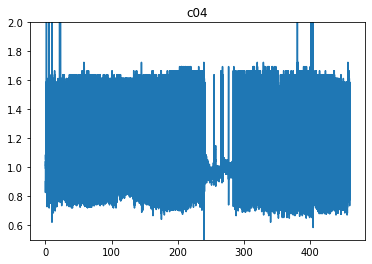

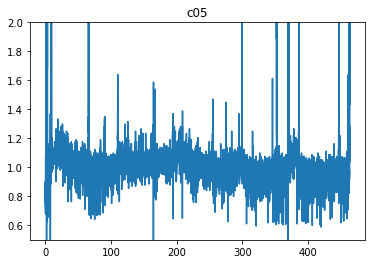

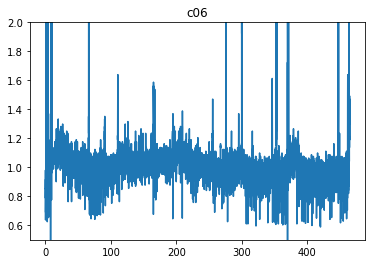

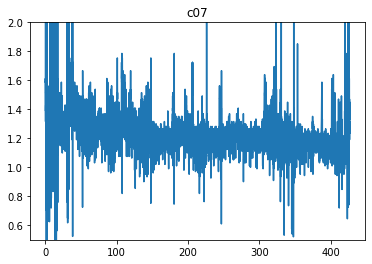

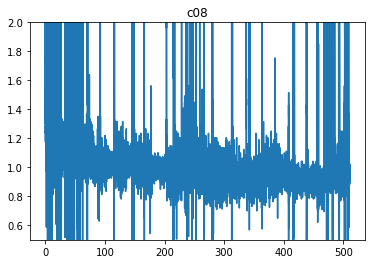

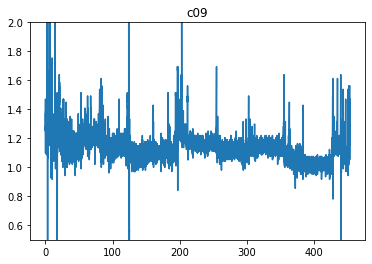

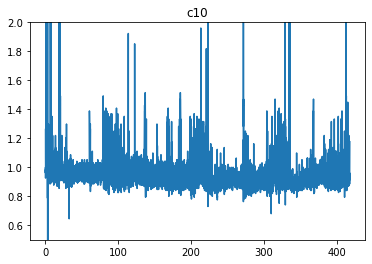

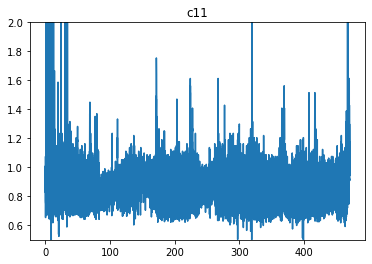

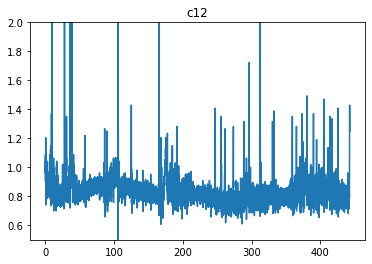

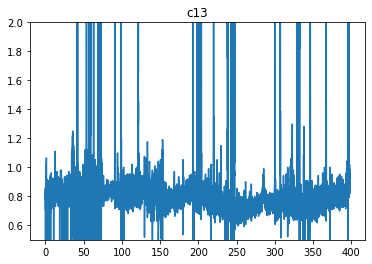

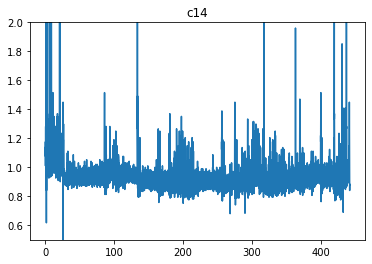

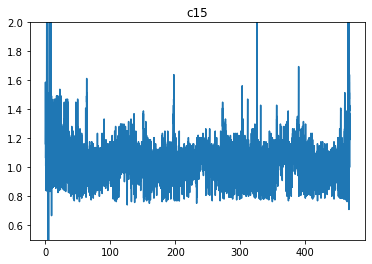

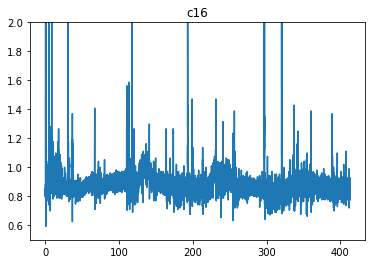

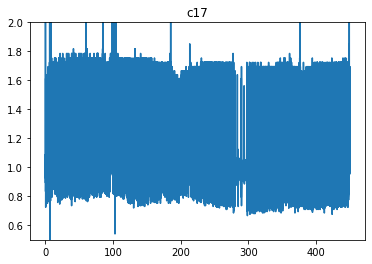

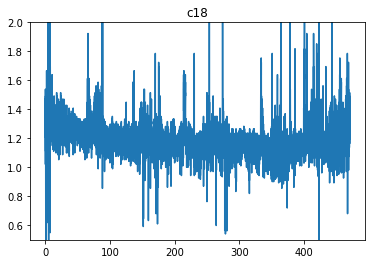

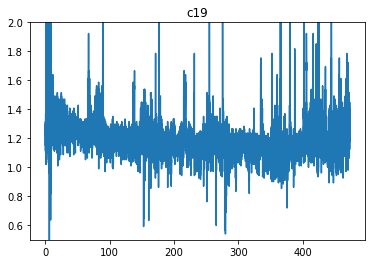

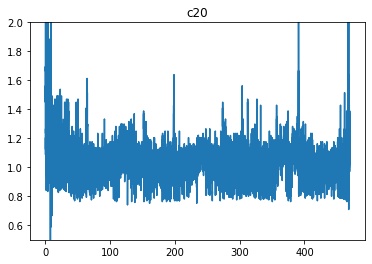

In [15]:
file_full = [f'a{i:02d}' for i in range(1, 41)] +\
    [f'b{i:02d}' for i in range(1, 11)] +\
    [f'c{i:02d}' for i in range(1, 21)]
for file in file_full:
    with open(f'../HR_data/{file}.pkl', 'rb') as f:
        res = pickle.load(f)
    
    plt.figure()
    plt.plot(res['t'], res['hr'])
    plt.ylim([0.5, 2])
    plt.title(file)
    plt.show()

# 6. Overall data properties

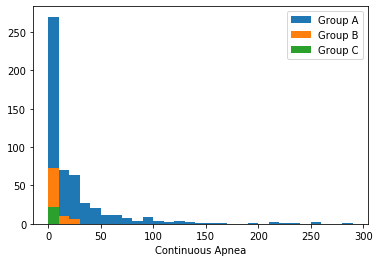

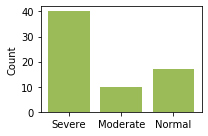

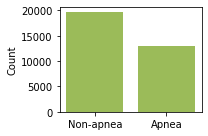

1.5037230367697858


In [57]:
file_full = [f'a{i:02d}' for i in range(1, 41)] + \
    [f'b{i:02d}' for i in range(1, 11)] + \
    [f'c{i:02d}' for i in range(1, 21)]

duration = []
pos_num, neg_num = 0, 0
patient_num = {'A': 0, 'B': 0, 'C': 0}
apn_duration = {'A': [], 'B': [], 'C': []}
for file in file_full:
    if not os.path.exists(f'../HR_data/{file}.pkl'):
        continue
        
    with open(f'../data/processed/{file}.pkl', 'rb') as f:
        res = pickle.load(f)
        apn = res['apn']
        group = file[0].upper()
        
    # Continuous apnea duration
    apn = np.array2string(apn.astype(int)) # Convert label to string 00011...
    apn = ''.join(re.split(' |\n',apn)) # Remove space and line break
    apn_duration[group].append(list(map(len, re.findall(r'1+', apn)))) # Length of continuous 1

    # Number of apnea and non-apnea minutes
    pos_num += len(re.findall(r'1', apn))
    neg_num += len(re.findall(r'0', apn))

    # Number of each diagnosis group
    patient_num[group] += 1 

duration_A = np.hstack(apn_duration['A'])
duration_B = np.hstack(apn_duration['B'])
duration_C = np.hstack(apn_duration['C'])

plt.hist(duration_A, np.arange(0, 300, 10))
plt.hist(duration_B, np.arange(0, 300, 10))
plt.hist(duration_C, np.arange(0, 300, 10))
plt.legend(['Group A', 'Group B', 'Group C'])
plt.xlabel('Continuous Apnea')
plt.show()

fig = plt.figure(figsize=(3, 2))
plt.bar(range(3), patient_num.values(), color=np.array([155, 187, 89])/255)
plt.xticks(range(3), labels=['Severe', 'Moderate', 'Normal'])
plt.ylabel('Count')
plt.tight_layout()
plt.show()
# fig.savefig('../archive/Data_Group.png', dpi=300)

fig = plt.figure(figsize=(3, 2))
plt.bar([0, 1], [neg_num, pos_num], color=np.array([155, 187, 89])/255)
plt.xticks([0, 1], labels=['Non-apnea', 'Apnea'])
plt.ylabel('Count')
plt.tight_layout()
plt.show()
# fig.savefig('../archive/Data_Minute.png', dpi=300)
print(neg_num / pos_num)

# 7. Train test split based on group

In [3]:
file_full = [f'a{i:02d}' for i in range(1, 41)] + \
    [f'b{i:02d}' for i in range(1, 11)] + \
    [f'c{i:02d}' for i in range(1, 21)]

df = pd.DataFrame(columns=['file', 'group'])
for file in file_full:
    if not os.path.exists(f'../HR_data/{file}.pkl'):
        continue
        
    with open(f'../HR_data/{file}.pkl', 'rb') as f:
        data = pickle.load(f)
        
    group = file[0].upper()
    df = df.append({
        'file': file,
        'pos': sum(data['apn']),
        'neg': sum(1 - data['apn']),
        'group': group,
    }, ignore_index=True)

df_train, df_test = train_test_split(
    df, test_size=0.2, stratify=df.group, random_state=1)

1.528910303928836


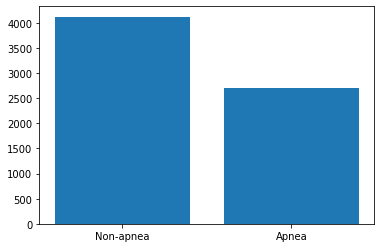

In [16]:
plt.bar(x=['Non-apnea', 'Apnea'], height=[df_test['neg'].sum(), df_test['pos'].sum()])
print(df_test['neg'].sum() / df_test['pos'].sum())

In [4]:
df.to_csv('../resources/File_all.csv', index=False)
df_test.to_csv('../resources/File_test.csv', index=False)
df_train.to_csv('../resources/File_train.csv', index=False)

# 8. Wavelet spectrogram for end-to-end model

In [2]:
def extract_cwt(file_names):
    df = pd.DataFrame()
    for file in file_names:
        cwt, apn, group = util.get_cwt(file, fs_new=1, smooth=True, cwt_width=40, 
                                  return_segments=True, segment_window=3)
        df_temp = pd.DataFrame({
            'cwt': cwt,
            'apn': apn, 
            'group': [group] * len(apn),
            'file': [file] * len(apn),
        })
        df = pd.concat([df, df_temp], axis=0, ignore_index=True)
        
    df['apn'] = df['apn'].astype(int)
    return df

### Arrange cwt results 

-3.0740391445543183 6.679678292849345


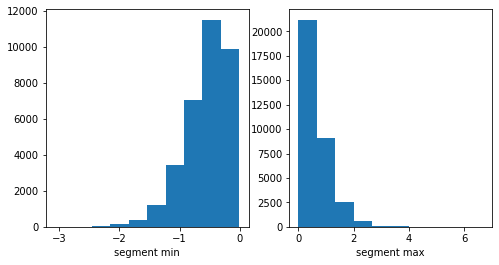

In [6]:
file_df = pd.read_csv('../resources/File_all.csv')
df = extract_cwt(file_df['file'])
with open('C:/Users/joey3/Desktop/Apnea_Raw/cwt_all.pkl', 'wb') as f:
    pickle.dump(df, f)

df['min'] = df['cwt'].apply(np.min)
df['max'] = df['cwt'].apply(np.max)

print(np.min(df['min']), np.max(df['max']))

fig = plt.figure(figsize=(8, 4))
fig.add_subplot(1, 2, 1)
plt.hist(df['min'])
plt.xlabel('segment min')
fig.add_subplot(1, 2, 2)
plt.hist(df['max'])
plt.xlabel('segment max')
plt.show()

### Generate images 

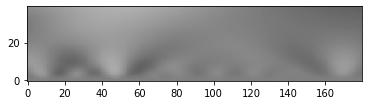

In [7]:
with open('C:/Users/joey3/Desktop/Apnea_Raw/cwt_all.pkl', 'rb') as f:
    df = pickle.load(f)

# Sample image
plt.imshow(
    df['cwt'][0], cmap='gray', aspect='equal', origin='lower',
    vmin=-2, vmax=2,
)

In [9]:
file_df = pd.read_csv('../resources/File_all.csv')
data_folder = 'C:/Users/joey3/Desktop/Apnea_Raw'

for file in file_df['file']:
    if not os.path.isdir(f'{data_folder}/{file}'):
        os.mkdir(f'{data_folder}/{file}')
        
    # Generate folders
    for subfolder in ['0', '1']:
        if not os.path.isdir(f'{data_folder}/{file}/{subfolder}'):
            os.mkdir(f'{data_folder}/{file}/{subfolder}')
    
    # Extract df
    df_temp = df[df['file'] == file]
    
    # Generate images 
    for index, row in df_temp.iterrows():
        subfolder = '1' if row['apn'] else '0'
        plt.imsave(
            f'{data_folder}/{file}/{subfolder}/{index}.png', row['cwt'], 
            cmap='gray', origin='lower',
            vmin=-2, vmax=2,
        )